## このノートブックの流れ

1.ノートブックから特徴量を写経で入れる

2.欠損値等のフォーマットを作成

3.パラメーター探索

# https://www.kaggle.com/wrecked22/simple-xgboost-with-feature-engineering-and-eda

# https://www.kaggle.com/rohan9889/xgb-lgbm-pipeline-featureengineering-house-price#Feature-Engineering-intuition

## 003をもとに、別の特徴量を作っていく。参考にしているのは上記のノートブック。

In [39]:
%matplotlib inline                      
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns                   # for beautiful plots
from scipy import stats                 # to calculate mode, skew and ANOVA, etc.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew #for some statistics

# importing alll the necessary packages to use the various classification algorithms
from sklearn.linear_model import LogisticRegression  # for Logistic Regression algorithm
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
from sklearn import metrics #for checking the model accuracy
from sklearn.metrics import mean_squared_error #for checking the model accuracy
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [40]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [41]:
train = import_data('../house price/train.csv')
test = import_data('../house price/test.csv')
Id = test.Id
target = train.SalePrice

Memory usage of dataframe is 0.90 MB
Memory usage after optimization is: 0.16 MB
Decreased by 81.7%
Memory usage of dataframe is 0.89 MB
Memory usage after optimization is: 0.16 MB
Decreased by 81.7%


In [42]:
alldata = import_data('../house price/alldata.csv')
alldata = alldata.iloc[:,2:]
alldata.head()

Memory usage of dataframe is 2.82 MB
Memory usage after optimization is: 0.47 MB
Decreased by 83.3%


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SimplKitchenQual,SimplHeatingQC,SimplBsmtFinType1,SimplBsmtFinType2,SimplBsmtCond,SimplBsmtQual,SimplExterCond,SimplExterQual,NeighborhoodBin,Neighborhood_Good
0,60,3,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,2,2,2,1,1,2,1,2,2,0.0
1,20,3,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,1,2,2,1,1,2,1,1,3,0.0
2,60,3,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,2,2,2,1,1,2,1,2,2,0.0
3,70,3,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,2,2,2,1,2,1,1,1,3,1.0
4,60,3,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,2,2,2,1,1,2,1,2,4,1.0


In [43]:
old_cols = train.columns.drop('Id')
old_cols

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [44]:
alldata2 = alldata[old_cols]

In [45]:
alldata['cond*qual'] = (alldata2['OverallCond'] * alldata2['OverallQual']) / 100.0
alldata['total_porch_area'] = alldata2['WoodDeckSF'] + alldata2['OpenPorchSF'] + alldata2['EnclosedPorch'] + alldata2['3SsnPorch'] + alldata2['ScreenPorch'] 
alldata['Totalsqrfootage'] = (alldata2['BsmtFinSF1'] + alldata2['BsmtFinSF2'] + alldata2['1stFlrSF'] + alldata2['2ndFlrSF'])
alldata['Total_Bathrooms'] = (alldata2['FullBath'] + (0.5 * alldata2['HalfBath']) + alldata2['BsmtFullBath'] + (0.5 * alldata2['BsmtHalfBath']))

In [46]:
alldata['GarageStatus'] = alldata2['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
alldata['BsmtStatus'] = alldata2['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
alldata['FirePlaceStatus'] = alldata2['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
alldata['PoolStatus'] = alldata2['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

In [47]:
alldata[alldata['GarageYrBlt'] == 2208]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,NeighborhoodBin,Neighborhood_Good,cond*qual,total_porch_area,Totalsqrfootage,Total_Bathrooms,GarageStatus,BsmtStatus,FirePlaceStatus,PoolStatus
2588,20,3,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,...,3,0.0,0.4,132,2147.0,2.0,1,1,1,0


In [48]:
alldata.loc[2558, 'GarageYrBlt'] = 2008

In [49]:
train_new = alldata[alldata['SalePrice'].notnull()]
test_new = alldata[alldata['SalePrice'].isnull()]

print("Train", train_new.shape)
print ('----------------')
print("Test", test_new.shape)

Train (1456, 133)
----------------
Test (1459, 133)


## モデリング（準備）

In [50]:
data = alldata

In [51]:
data['SalePrice'] = np.log(data['SalePrice'])
data['SalePrice']

0       12.247694
1       12.109011
2       12.317166
3       11.849398
4       12.429216
          ...    
2910          NaN
2911          NaN
2912          NaN
2913          NaN
2914          NaN
Name: SalePrice, Length: 2915, dtype: float32

In [52]:
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [53]:
train = data[:len(train_new)]
test = data[len(train_new):]

In [54]:
categorical_cols = list(data.select_dtypes(include=['category']).columns)
print(categorical_cols)

['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleCondition']


In [56]:
from sklearn import preprocessing
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, col_definition: dict):
    """
    col_definition: encode_col
    """
    n_train = len(train)
    train = data
    for f in col_definition['encode_col']:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

train, test = label_encoding(train, test, col_definition={'encode_col': categorical_cols})
print(train.shape, test.shape)

(1456, 133) (1459, 133)


In [57]:
X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test.drop('SalePrice', axis=1)

In [59]:
categorical_cols = ['Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition',
       'IsRegularLotShape', 'IsLandLevel',
       'IsLandSlopeGentle', 'IsElectricalSBrkr', 'IsGarageDetached',
       'IsPavedDrive', 'HasShed', 'Remodeled',
       'VeryNewHouse', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
       'HasOpenPorch', 'HasEnclosedPorch', 'Has3SsnPorch',
       'HasScreenPorch', 'HighSeason', 'NewerDwelling',
       'SaleCondition_PriceDown', 'BoughtOffPlan', 'BadHeating',
       'TimeSinceSold', 'SeasonSold', 'NeighborhoodBin']

## モデリング（lightgbm）

In [60]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'num_leaves': 24,
    'max_depth': 6,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.265255	valid_1's rmse: 0.266169
[20]	training's rmse: 0.18795	valid_1's rmse: 0.197711
[30]	training's rmse: 0.142042	valid_1's rmse: 0.158662
[40]	training's rmse: 0.115616	valid_1's rmse: 0.138242
[50]	training's rmse: 0.0996789	valid_1's rmse: 0.128503
[60]	training's rmse: 0.0901709	valid_1's rmse: 0.123096
[70]	training's rmse: 0.083897	valid_1's rmse: 0.120611
[80]	training's rmse: 0.0794663	valid_1's rmse: 0.119064
[90]	training's rmse: 0.0759809	valid_1's rmse: 0.11782
[100]	training's rmse: 0.0730978	valid_1's rmse: 0.116832
[110]	training's rmse: 0.070614	valid_1's rmse: 0.116448
[120]	training's rmse: 0.0680302	valid_1's rmse: 0.116204
[130]	training's rmse: 0.0657571	valid_1's rmse: 0.116194
Early stopping, best iteration is:
[124]	training's rmse: 0.0671559	valid_1's rmse: 0.115958
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.261692	valid_1's rmse: 0

In [61]:
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

CV: 0.12233257565628454


In [62]:
sub = pd.DataFrame({'Id': Id, 'SalePrice': 0})
y_sub = sum(y_preds) / len(y_preds)
y_sub = np.expm1(y_sub)
sub['SalePrice'] = y_sub
sub.to_csv('submission.csv', index=False)
# 0.12936

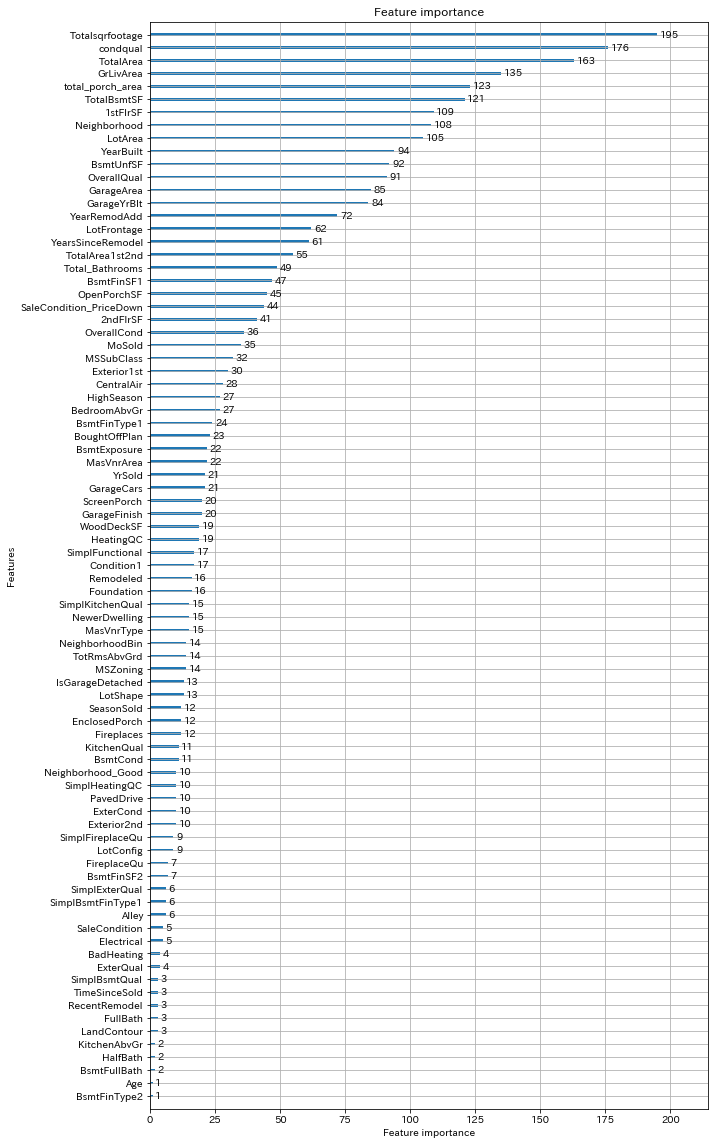

In [63]:
lgb.plot_importance(model, figsize=(10,20))

In [65]:
data.to_csv('004_data.csv')

# パラメーターチューニング

## learning_rate : 0.5

### max_depth

#### -1, 7, 4, 10, 3, 2, 1の順番で調べた。２がベストとなった。

In [70]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'max_depth': -1,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=20,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.184507	valid_1's rmse: 0.19562
[40]	training's rmse: 0.111003	valid_1's rmse: 0.138101
[60]	training's rmse: 0.0837756	valid_1's rmse: 0.123402
[80]	training's rmse: 0.0703309	valid_1's rmse: 0.118986
[100]	training's rmse: 0.0612355	valid_1's rmse: 0.117191
[120]	training's rmse: 0.0543569	valid_1's rmse: 0.116373
Early stopping, best iteration is:
[118]	training's rmse: 0.0550102	valid_1's rmse: 0.116327
Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.181035	valid_1's rmse: 0.203871
[40]	training's rmse: 0.107084	valid_1's rmse: 0.143693
[60]	training's rmse: 0.0805339	valid_1's rmse: 0.131264
[80]	training's rmse: 0.0668151	valid_1's rmse: 0.128767
[100]	training's rmse: 0.0577156	valid_1's rmse: 0.12829
Early stopping, best iteration is:
[96]	training's rmse: 0.0593579	valid_1's rmse: 0.128211
Training until validation scores don't improve for 10 rounds
[20]	tra

In [71]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'max_depth': 7,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=20,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.184679	valid_1's rmse: 0.195428
[40]	training's rmse: 0.111451	valid_1's rmse: 0.137865
[60]	training's rmse: 0.0853505	valid_1's rmse: 0.122786
[80]	training's rmse: 0.0740872	valid_1's rmse: 0.118034
[100]	training's rmse: 0.0677203	valid_1's rmse: 0.116024
[120]	training's rmse: 0.0629677	valid_1's rmse: 0.115144
[140]	training's rmse: 0.0586124	valid_1's rmse: 0.114561
Early stopping, best iteration is:
[137]	training's rmse: 0.0592495	valid_1's rmse: 0.114505
Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.181219	valid_1's rmse: 0.203859
[40]	training's rmse: 0.10753	valid_1's rmse: 0.144922
[60]	training's rmse: 0.0816479	valid_1's rmse: 0.132804
[80]	training's rmse: 0.0695031	valid_1's rmse: 0.129904
[100]	training's rmse: 0.063573	valid_1's rmse: 0.128956
Early stopping, best iteration is:
[98]	training's rmse: 0.064023	valid_1's rmse: 0.12891
Training unti

In [72]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'max_depth': 4,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=20,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.196124	valid_1's rmse: 0.202358
[40]	training's rmse: 0.125993	valid_1's rmse: 0.141013
[60]	training's rmse: 0.101378	valid_1's rmse: 0.124094
[80]	training's rmse: 0.0910517	valid_1's rmse: 0.118983
[100]	training's rmse: 0.0852442	valid_1's rmse: 0.116637
[120]	training's rmse: 0.0811186	valid_1's rmse: 0.115656
[140]	training's rmse: 0.0770372	valid_1's rmse: 0.114796
[160]	training's rmse: 0.0737455	valid_1's rmse: 0.114492
[180]	training's rmse: 0.0708771	valid_1's rmse: 0.113968
[200]	training's rmse: 0.0681154	valid_1's rmse: 0.11364
Early stopping, best iteration is:
[206]	training's rmse: 0.0675279	valid_1's rmse: 0.113459
Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.193997	valid_1's rmse: 0.211435
[40]	training's rmse: 0.123308	valid_1's rmse: 0.145744
[60]	training's rmse: 0.0990152	valid_1's rmse: 0.129692
[80]	training's rmse: 0.0890057	valid_1's rm

In [73]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'max_depth': 10,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=20,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.184507	valid_1's rmse: 0.19562
[40]	training's rmse: 0.111003	valid_1's rmse: 0.138101
[60]	training's rmse: 0.0839481	valid_1's rmse: 0.123751
[80]	training's rmse: 0.0707379	valid_1's rmse: 0.118524
[100]	training's rmse: 0.0623376	valid_1's rmse: 0.116622
[120]	training's rmse: 0.056258	valid_1's rmse: 0.116001
[140]	training's rmse: 0.0514789	valid_1's rmse: 0.115888
Early stopping, best iteration is:
[141]	training's rmse: 0.0513674	valid_1's rmse: 0.115886
Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.181035	valid_1's rmse: 0.203871
[40]	training's rmse: 0.107084	valid_1's rmse: 0.143693
[60]	training's rmse: 0.0805479	valid_1's rmse: 0.131253
[80]	training's rmse: 0.0670701	valid_1's rmse: 0.129068
[100]	training's rmse: 0.059018	valid_1's rmse: 0.12827
Early stopping, best iteration is:
[91]	training's rmse: 0.0622478	valid_1's rmse: 0.128198
Training unti

In [74]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'max_depth': 5,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=20,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.188587	valid_1's rmse: 0.197427
[40]	training's rmse: 0.116535	valid_1's rmse: 0.139052
[60]	training's rmse: 0.0924617	valid_1's rmse: 0.122968
[80]	training's rmse: 0.0825272	valid_1's rmse: 0.118733
[100]	training's rmse: 0.0772823	valid_1's rmse: 0.117246
[120]	training's rmse: 0.0727047	valid_1's rmse: 0.116268
[140]	training's rmse: 0.0686107	valid_1's rmse: 0.115336
Early stopping, best iteration is:
[149]	training's rmse: 0.0669388	valid_1's rmse: 0.11528
Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.186113	valid_1's rmse: 0.207809
[40]	training's rmse: 0.113596	valid_1's rmse: 0.14542
[60]	training's rmse: 0.0893067	valid_1's rmse: 0.132247
[80]	training's rmse: 0.0789607	valid_1's rmse: 0.128363
[100]	training's rmse: 0.0739811	valid_1's rmse: 0.127178
[120]	training's rmse: 0.0700348	valid_1's rmse: 0.126591
Early stopping, best iteration is:
[122]	trai

In [75]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'max_depth': 3,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=20,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.210965	valid_1's rmse: 0.212959
[40]	training's rmse: 0.142287	valid_1's rmse: 0.148591
[60]	training's rmse: 0.11595	valid_1's rmse: 0.127778
[80]	training's rmse: 0.104259	valid_1's rmse: 0.120855
[100]	training's rmse: 0.0986	valid_1's rmse: 0.117531
[120]	training's rmse: 0.0947792	valid_1's rmse: 0.1158
[140]	training's rmse: 0.0911583	valid_1's rmse: 0.114472
[160]	training's rmse: 0.0877682	valid_1's rmse: 0.113645
[180]	training's rmse: 0.0848187	valid_1's rmse: 0.112738
[200]	training's rmse: 0.0820475	valid_1's rmse: 0.111771
[220]	training's rmse: 0.0799886	valid_1's rmse: 0.111405
[240]	training's rmse: 0.0779753	valid_1's rmse: 0.110848
Early stopping, best iteration is:
[242]	training's rmse: 0.0778398	valid_1's rmse: 0.110756
Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.20802	valid_1's rmse: 0.224733
[40]	training's rmse: 0.139443	valid_1's rmse: 0

In [76]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'max_depth': 2,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=20,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.234713	valid_1's rmse: 0.233381
[40]	training's rmse: 0.167593	valid_1's rmse: 0.16942
[60]	training's rmse: 0.137825	valid_1's rmse: 0.139932
[80]	training's rmse: 0.123484	valid_1's rmse: 0.128539
[100]	training's rmse: 0.115742	valid_1's rmse: 0.122948
[120]	training's rmse: 0.110815	valid_1's rmse: 0.119913
[140]	training's rmse: 0.107522	valid_1's rmse: 0.118207
[160]	training's rmse: 0.105056	valid_1's rmse: 0.116934
[180]	training's rmse: 0.102903	valid_1's rmse: 0.116088
[200]	training's rmse: 0.100912	valid_1's rmse: 0.115325
[220]	training's rmse: 0.0990295	valid_1's rmse: 0.114413
[240]	training's rmse: 0.0973717	valid_1's rmse: 0.113852
[260]	training's rmse: 0.0958961	valid_1's rmse: 0.113378
[280]	training's rmse: 0.0944125	valid_1's rmse: 0.112935
[300]	training's rmse: 0.0931662	valid_1's rmse: 0.112471
[320]	training's rmse: 0.0920559	valid_1's rmse: 0.112201
[340]	training's rmse: 0.0

In [77]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'max_depth': 1,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=20,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.284838	valid_1's rmse: 0.276937
[40]	training's rmse: 0.22634	valid_1's rmse: 0.219228
[60]	training's rmse: 0.192344	valid_1's rmse: 0.186396
[80]	training's rmse: 0.17038	valid_1's rmse: 0.164726
[100]	training's rmse: 0.155676	valid_1's rmse: 0.150811
[120]	training's rmse: 0.145419	valid_1's rmse: 0.140734
[140]	training's rmse: 0.138	valid_1's rmse: 0.133868
[160]	training's rmse: 0.132344	valid_1's rmse: 0.129103
[180]	training's rmse: 0.127987	valid_1's rmse: 0.125661
[200]	training's rmse: 0.124545	valid_1's rmse: 0.123122
[220]	training's rmse: 0.121834	valid_1's rmse: 0.121362
[240]	training's rmse: 0.119672	valid_1's rmse: 0.120013
[260]	training's rmse: 0.117919	valid_1's rmse: 0.119079
[280]	training's rmse: 0.116468	valid_1's rmse: 0.118242
[300]	training's rmse: 0.11523	valid_1's rmse: 0.117584
[320]	training's rmse: 0.114174	valid_1's rmse: 0.116955
[340]	training's rmse: 0.113266	valid

[580]	training's rmse: 0.107702	valid_1's rmse: 0.10886
[600]	training's rmse: 0.107333	valid_1's rmse: 0.108547
[620]	training's rmse: 0.106982	valid_1's rmse: 0.108396
[640]	training's rmse: 0.106641	valid_1's rmse: 0.108058
[660]	training's rmse: 0.106316	valid_1's rmse: 0.107757
[680]	training's rmse: 0.106006	valid_1's rmse: 0.107555
Early stopping, best iteration is:
[686]	training's rmse: 0.105914	valid_1's rmse: 0.107486
CV: 0.1218776723669468


## maxdepthを３に固定してして「num_leaves」

### 4, 2, 6, 3, 5の順番に調べた。4がベスト。

In [82]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'max_depth': 3,
    'num_leaves': 4,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=20,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.234713	valid_1's rmse: 0.233443
[40]	training's rmse: 0.167787	valid_1's rmse: 0.167948
[60]	training's rmse: 0.138036	valid_1's rmse: 0.139164
[80]	training's rmse: 0.123385	valid_1's rmse: 0.128202
[100]	training's rmse: 0.115068	valid_1's rmse: 0.12183
[120]	training's rmse: 0.10984	valid_1's rmse: 0.119098
[140]	training's rmse: 0.106329	valid_1's rmse: 0.117029
[160]	training's rmse: 0.103451	valid_1's rmse: 0.115911
[180]	training's rmse: 0.100758	valid_1's rmse: 0.114683
[200]	training's rmse: 0.0985207	valid_1's rmse: 0.113786
[220]	training's rmse: 0.0966458	valid_1's rmse: 0.112854
[240]	training's rmse: 0.0948996	valid_1's rmse: 0.112253
[260]	training's rmse: 0.0932773	valid_1's rmse: 0.111636
[280]	training's rmse: 0.0917531	valid_1's rmse: 0.111187
Early stopping, best iteration is:
[289]	training's rmse: 0.0911067	valid_1's rmse: 0.111006
Training until validation scores don't improve fo

In [83]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'max_depth': 3,
    'num_leaves': 2,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=20,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.284838	valid_1's rmse: 0.276937
[40]	training's rmse: 0.22634	valid_1's rmse: 0.219228
[60]	training's rmse: 0.192344	valid_1's rmse: 0.186396
[80]	training's rmse: 0.17038	valid_1's rmse: 0.164726
[100]	training's rmse: 0.155676	valid_1's rmse: 0.150811
[120]	training's rmse: 0.145419	valid_1's rmse: 0.140734
[140]	training's rmse: 0.138	valid_1's rmse: 0.133868
[160]	training's rmse: 0.132344	valid_1's rmse: 0.129103
[180]	training's rmse: 0.127987	valid_1's rmse: 0.125661
[200]	training's rmse: 0.124545	valid_1's rmse: 0.123122
[220]	training's rmse: 0.121834	valid_1's rmse: 0.121362
[240]	training's rmse: 0.119672	valid_1's rmse: 0.120013
[260]	training's rmse: 0.117919	valid_1's rmse: 0.119079
[280]	training's rmse: 0.116468	valid_1's rmse: 0.118242
[300]	training's rmse: 0.11523	valid_1's rmse: 0.117584
[320]	training's rmse: 0.114174	valid_1's rmse: 0.116955
[340]	training's rmse: 0.113266	valid

[480]	training's rmse: 0.109833	valid_1's rmse: 0.110408
[500]	training's rmse: 0.109362	valid_1's rmse: 0.110186
[520]	training's rmse: 0.108914	valid_1's rmse: 0.109836
[540]	training's rmse: 0.108491	valid_1's rmse: 0.109542
[560]	training's rmse: 0.108087	valid_1's rmse: 0.109146
[580]	training's rmse: 0.107702	valid_1's rmse: 0.10886
[600]	training's rmse: 0.107333	valid_1's rmse: 0.108547
[620]	training's rmse: 0.106982	valid_1's rmse: 0.108396
[640]	training's rmse: 0.106641	valid_1's rmse: 0.108058
[660]	training's rmse: 0.106316	valid_1's rmse: 0.107757
[680]	training's rmse: 0.106006	valid_1's rmse: 0.107555
Early stopping, best iteration is:
[686]	training's rmse: 0.105914	valid_1's rmse: 0.107486
CV: 0.1218776723669468


In [84]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'max_depth': 3,
    'num_leaves': 6,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=20,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.219845	valid_1's rmse: 0.220737
[40]	training's rmse: 0.150816	valid_1's rmse: 0.154634
[60]	training's rmse: 0.123471	valid_1's rmse: 0.130615
[80]	training's rmse: 0.110668	valid_1's rmse: 0.121743
[100]	training's rmse: 0.104239	valid_1's rmse: 0.117827
[120]	training's rmse: 0.0997927	valid_1's rmse: 0.115458
[140]	training's rmse: 0.0961911	valid_1's rmse: 0.114006
[160]	training's rmse: 0.0929949	valid_1's rmse: 0.112552
[180]	training's rmse: 0.0901188	valid_1's rmse: 0.111703
[200]	training's rmse: 0.0876577	valid_1's rmse: 0.110921
[220]	training's rmse: 0.0853658	valid_1's rmse: 0.110186
[240]	training's rmse: 0.083382	valid_1's rmse: 0.109609
[260]	training's rmse: 0.0816746	valid_1's rmse: 0.109462
[280]	training's rmse: 0.0798435	valid_1's rmse: 0.109135
[300]	training's rmse: 0.0783895	valid_1's rmse: 0.108873
[320]	training's rmse: 0.0768941	valid_1's rmse: 0.108717
[340]	training's rmse

In [85]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'max_depth': 3,
    'num_leaves': 3,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=20,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.252409	valid_1's rmse: 0.247124
[40]	training's rmse: 0.187749	valid_1's rmse: 0.183973
[60]	training's rmse: 0.154861	valid_1's rmse: 0.151032
[80]	training's rmse: 0.13726	valid_1's rmse: 0.135451
[100]	training's rmse: 0.126769	valid_1's rmse: 0.127208
[120]	training's rmse: 0.120196	valid_1's rmse: 0.12264
[140]	training's rmse: 0.115822	valid_1's rmse: 0.120145
[160]	training's rmse: 0.112722	valid_1's rmse: 0.11866
[180]	training's rmse: 0.110299	valid_1's rmse: 0.117354
[200]	training's rmse: 0.108277	valid_1's rmse: 0.116392
[220]	training's rmse: 0.106454	valid_1's rmse: 0.115675
[240]	training's rmse: 0.104835	valid_1's rmse: 0.114893
[260]	training's rmse: 0.103381	valid_1's rmse: 0.114
[280]	training's rmse: 0.102056	valid_1's rmse: 0.113516
[300]	training's rmse: 0.100784	valid_1's rmse: 0.113136
[320]	training's rmse: 0.0996705	valid_1's rmse: 0.112557
[340]	training's rmse: 0.0986464	val

In [86]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'max_depth': 3,
    'num_leaves': 5,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=20,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.225954	valid_1's rmse: 0.224708
[40]	training's rmse: 0.158028	valid_1's rmse: 0.160351
[60]	training's rmse: 0.129246	valid_1's rmse: 0.134797
[80]	training's rmse: 0.115803	valid_1's rmse: 0.124372
[100]	training's rmse: 0.108586	valid_1's rmse: 0.119638
[120]	training's rmse: 0.103914	valid_1's rmse: 0.117274
[140]	training's rmse: 0.100271	valid_1's rmse: 0.115372
[160]	training's rmse: 0.0972435	valid_1's rmse: 0.114506
[180]	training's rmse: 0.0944594	valid_1's rmse: 0.113662
[200]	training's rmse: 0.0920869	valid_1's rmse: 0.112846
[220]	training's rmse: 0.0900317	valid_1's rmse: 0.112281
[240]	training's rmse: 0.0881046	valid_1's rmse: 0.111849
[260]	training's rmse: 0.0863592	valid_1's rmse: 0.111473
[280]	training's rmse: 0.084643	valid_1's rmse: 0.111021
[300]	training's rmse: 0.0831043	valid_1's rmse: 0.11074
Early stopping, best iteration is:
[298]	training's rmse: 0.0832603	valid_1's rmse

## max_depth: 3, num_leaves: 4でlearning_rateを変更(悪化)

In [90]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'max_depth': 3,
    'num_leaves': 4,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=20,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.350929	valid_1's rmse: 0.345565
[40]	training's rmse: 0.314122	valid_1's rmse: 0.310103
[60]	training's rmse: 0.283559	valid_1's rmse: 0.280828
[80]	training's rmse: 0.257884	valid_1's rmse: 0.255893
[100]	training's rmse: 0.236419	valid_1's rmse: 0.235265
[120]	training's rmse: 0.218295	valid_1's rmse: 0.217576
[140]	training's rmse: 0.202694	valid_1's rmse: 0.20232
[160]	training's rmse: 0.18963	valid_1's rmse: 0.189796
[180]	training's rmse: 0.17855	valid_1's rmse: 0.178855
[200]	training's rmse: 0.169067	valid_1's rmse: 0.169277
[220]	training's rmse: 0.161022	valid_1's rmse: 0.161289
[240]	training's rmse: 0.154154	valid_1's rmse: 0.154426
[260]	training's rmse: 0.148234	valid_1's rmse: 0.1487
[280]	training's rmse: 0.143176	valid_1's rmse: 0.144042
[300]	training's rmse: 0.138817	valid_1's rmse: 0.140057
[320]	training's rmse: 0.135033	valid_1's rmse: 0.13681
[340]	training's rmse: 0.131712	valid

Training until validation scores don't improve for 10 rounds
[20]	training's rmse: 0.354474	valid_1's rmse: 0.328018
[40]	training's rmse: 0.316637	valid_1's rmse: 0.293668
[60]	training's rmse: 0.285249	valid_1's rmse: 0.265708
[80]	training's rmse: 0.259084	valid_1's rmse: 0.242333
[100]	training's rmse: 0.237018	valid_1's rmse: 0.222368
[120]	training's rmse: 0.218509	valid_1's rmse: 0.20619
[140]	training's rmse: 0.202843	valid_1's rmse: 0.193064
[160]	training's rmse: 0.189415	valid_1's rmse: 0.182472
[180]	training's rmse: 0.178046	valid_1's rmse: 0.173517
[200]	training's rmse: 0.16833	valid_1's rmse: 0.166215
[220]	training's rmse: 0.159801	valid_1's rmse: 0.160079
[240]	training's rmse: 0.152566	valid_1's rmse: 0.154862
[260]	training's rmse: 0.146348	valid_1's rmse: 0.150439
[280]	training's rmse: 0.141083	valid_1's rmse: 0.147007
[300]	training's rmse: 0.136616	valid_1's rmse: 0.144272
[320]	training's rmse: 0.132702	valid_1's rmse: 0.142075
[340]	training's rmse: 0.129289	v

## ここまでで一旦submit

In [143]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'max_depth': 3,
    'num_leaves': 4,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.296559	valid_1's rmse: 0.293529
[20]	training's rmse: 0.234713	valid_1's rmse: 0.233443
[30]	training's rmse: 0.194235	valid_1's rmse: 0.193909
[40]	training's rmse: 0.167787	valid_1's rmse: 0.167948
[50]	training's rmse: 0.149996	valid_1's rmse: 0.150402
[60]	training's rmse: 0.138036	valid_1's rmse: 0.139164
[70]	training's rmse: 0.129624	valid_1's rmse: 0.132554
[80]	training's rmse: 0.123385	valid_1's rmse: 0.128202
[90]	training's rmse: 0.118646	valid_1's rmse: 0.124353
[100]	training's rmse: 0.115068	valid_1's rmse: 0.12183
[110]	training's rmse: 0.112175	valid_1's rmse: 0.120378
[120]	training's rmse: 0.10984	valid_1's rmse: 0.119098
[130]	training's rmse: 0.107981	valid_1's rmse: 0.117886
[140]	training's rmse: 0.106329	valid_1's rmse: 0.117029
[150]	training's rmse: 0.10484	valid_1's rmse: 0.116449
[160]	training's rmse: 0.103451	valid_1's rmse: 0.115911
[170]	training's rmse: 0.102056	valid_1

[110]	training's rmse: 0.112946	valid_1's rmse: 0.115295
[120]	training's rmse: 0.110499	valid_1's rmse: 0.113507
[130]	training's rmse: 0.108478	valid_1's rmse: 0.112062
[140]	training's rmse: 0.106779	valid_1's rmse: 0.110937
[150]	training's rmse: 0.105228	valid_1's rmse: 0.110455
[160]	training's rmse: 0.103854	valid_1's rmse: 0.109697
[170]	training's rmse: 0.102433	valid_1's rmse: 0.109099
[180]	training's rmse: 0.101155	valid_1's rmse: 0.108658
[190]	training's rmse: 0.100045	valid_1's rmse: 0.108146
[200]	training's rmse: 0.0989354	valid_1's rmse: 0.107842
[210]	training's rmse: 0.0979981	valid_1's rmse: 0.107535
[220]	training's rmse: 0.097029	valid_1's rmse: 0.107266
[230]	training's rmse: 0.0960956	valid_1's rmse: 0.107134
[240]	training's rmse: 0.0952737	valid_1's rmse: 0.106917
[250]	training's rmse: 0.0944864	valid_1's rmse: 0.106687
[260]	training's rmse: 0.0936968	valid_1's rmse: 0.106506
[270]	training's rmse: 0.0929691	valid_1's rmse: 0.106219
[280]	training's rmse: 0

In [144]:
sub = pd.DataFrame({'Id': Id, 'SalePrice': 0})
y_sub = sum(y_preds) / len(y_preds)
y_sub = np.expm1(y_sub)
sub['SalePrice'] = y_sub
sub.to_csv('submission.csv', index=False)
# 0.12971
# 下がった。

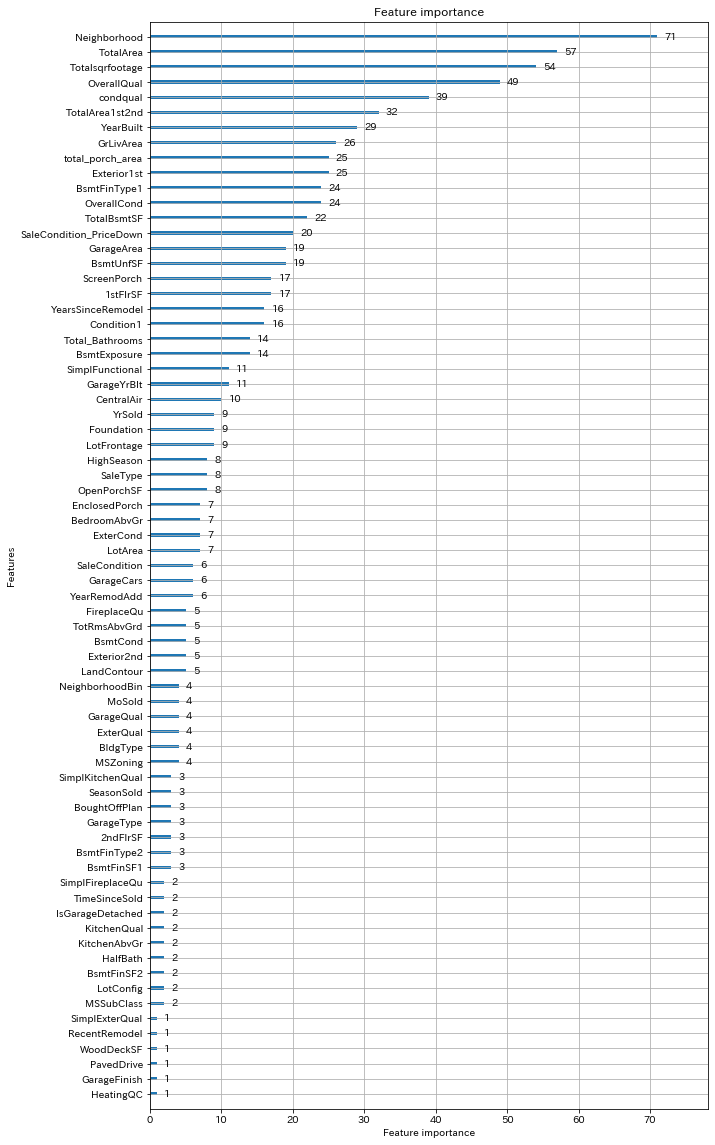

In [145]:
lgb.plot_importance(model, figsize=(10,20))

## いろいろいじる

In [142]:
# num_leaves以外を動かしても基本的に変化がない。num_leavesで決まっているようなもの感がすごい

y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'max_depth': 4,
    'num_leaves': 4,
    'objective': 'regression',
    'metric': 'rmse',
    #'bagging_fraction': いくつでも変化なし。,
    #'fearture_fraction': いくつでも変化なし。,
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=5,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 0.340102	valid_1's rmse: 0.335253
[10]	training's rmse: 0.296559	valid_1's rmse: 0.293529
[15]	training's rmse: 0.262284	valid_1's rmse: 0.26008
[20]	training's rmse: 0.234713	valid_1's rmse: 0.233443
[25]	training's rmse: 0.212402	valid_1's rmse: 0.211844
[30]	training's rmse: 0.194235	valid_1's rmse: 0.193909
[35]	training's rmse: 0.179573	valid_1's rmse: 0.179672
[40]	training's rmse: 0.167787	valid_1's rmse: 0.167948
[45]	training's rmse: 0.158021	valid_1's rmse: 0.158254
[50]	training's rmse: 0.149996	valid_1's rmse: 0.150402
[55]	training's rmse: 0.143476	valid_1's rmse: 0.144141
[60]	training's rmse: 0.138036	valid_1's rmse: 0.139164
[65]	training's rmse: 0.13354	valid_1's rmse: 0.135592
[70]	training's rmse: 0.129624	valid_1's rmse: 0.132554
[75]	training's rmse: 0.126344	valid_1's rmse: 0.130287
[80]	training's rmse: 0.123385	valid_1's rmse: 0.128202
[85]	training's rmse: 0.120862	valid_1's rmse:

[335]	training's rmse: 0.0817372	valid_1's rmse: 0.140181
[340]	training's rmse: 0.0814268	valid_1's rmse: 0.140007
[345]	training's rmse: 0.0811488	valid_1's rmse: 0.139934
[350]	training's rmse: 0.0809007	valid_1's rmse: 0.139817
[355]	training's rmse: 0.0806138	valid_1's rmse: 0.139696
[360]	training's rmse: 0.0803596	valid_1's rmse: 0.139695
[365]	training's rmse: 0.080126	valid_1's rmse: 0.139623
[370]	training's rmse: 0.0798579	valid_1's rmse: 0.139608
[375]	training's rmse: 0.0795666	valid_1's rmse: 0.139496
[380]	training's rmse: 0.0792754	valid_1's rmse: 0.139395
[385]	training's rmse: 0.0790135	valid_1's rmse: 0.139446
[390]	training's rmse: 0.078728	valid_1's rmse: 0.139412
Early stopping, best iteration is:
[380]	training's rmse: 0.0792754	valid_1's rmse: 0.139395
Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 0.343468	valid_1's rmse: 0.317639
[10]	training's rmse: 0.298606	valid_1's rmse: 0.27783
[15]	training's rmse: 0.263464	valid_1's r